In [ ]:
import os
import glob
import rasterio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# =============================
# 1. Preprocess Image Function
# =============================
def preprocess_image(image_path, size=(85, 85)):
    """
    Preprocess a TIFF image for model prediction.
    Args:
        image_path (str): Path to the TIFF file.
        size (tuple): Target size for resizing (height, width).
    Returns:
        np.array: Preprocessed image with batch dimension.
    """
    with rasterio.open(image_path) as src:
        # Read RGB bands (1=Red, 2=Green, 3=Blue)
        image = src.read([1, 2, 3])  # Ensure bands exist (adjust if needed)
        image = np.moveaxis(image, 0, -1)  # Rearrange dimensions to (H, W, C)

    # Normalize to [0, 1] (for 16-bit TIFF)
    image = image / 65535.0
    # Resize to match model input size
    image = tf.image.resize(image, size).numpy()
    # Add batch dimension
    return np.expand_dims(image, axis=0)

# =============================
# 2. Predict Images Function
# =============================
def predict_images(model, image_dir, size=(85, 85)):
    """
    Predict masks for all images in a directory.
    Args:
        model: Trained TensorFlow model.
        image_dir (str): Path to the directory containing TIFF images.
        size (tuple): Target size for resizing (height, width).
    Returns:
        list: Predicted masks.
        list: Corresponding file paths.
    """
    predictions = []
    file_paths = sorted(glob.glob(os.path.join(image_dir, "*.tiff")))

    print(f"Found {len(file_paths)} files in {image_dir}")
    for file_path in file_paths:
        try:
            print(f"Processing: {file_path}")
            # Preprocess image
            image = preprocess_image(file_path, size)
            # Predict using the model
            prediction = model.predict(image).squeeze()  # Remove batch dimension
            predictions.append(prediction)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    return predictions, file_paths

# =============================
# 3. Calculate Delta Function
# =============================
def calculate_delta(predictions_2016, predictions_2021):
    """
    Calculate pixel-wise delta between two sets of predictions.
    Args:
        predictions_2016 (list): Predictions for 2016.
        predictions_2021 (list): Predictions for 2021.
    Returns:
        list: Delta maps.
    """
    deltas = []
    for pred_2016, pred_2021 in zip(predictions_2016, predictions_2021):
        delta = pred_2021 - pred_2016  # Calculate pixel-wise difference
        deltas.append(delta)
    return deltas

# =============================
# 4. Save Delta Maps Function
# =============================
def save_deltas(deltas, file_paths, output_dir='data/filtered/deltas'):
    """
    Save delta maps as images.
    Args:
        deltas (list): List of delta maps.
        file_paths (list): Corresponding file paths for naming.
        output_dir (str): Directory to save delta maps.
    """
    os.makedirs(output_dir, exist_ok=True)
    for delta, file_path in zip(deltas, file_paths):
        file_name = os.path.basename(file_path).replace('.tiff', '_delta.png')  # Adjust extension
        output_path = os.path.join(output_dir, file_name)
        plt.imsave(output_path, delta, cmap='RdBu')  # Save with diverging colormap
        print(f"Saved delta map to: {output_path}")

# =============================
# 5. Main Workflow
# =============================
if __name__ == "__main__":
    # Load the trained model
    model = tf.keras.models.load_model('models/trained_model.keras')

    # Directories for images
    image_dir_2016 = 'data/filtered/images_2016'
    image_dir_2021 = 'data/filtered/images_2021'

    # Predict masks for 2016 and 2021
    predictions_2016, files_2016 = predict_images(model, image_dir_2016, size=(85, 85))
    predictions_2021, files_2021 = predict_images(model, image_dir_2021, size=(85, 85))

    # Ensure predictions are not empty
    print(f"Number of predictions for 2016: {len(predictions_2016)}")
    print(f"Number of predictions for 2021: {len(predictions_2021)}")

    # Calculate deltas
    deltas = calculate_delta(predictions_2016, predictions_2021)

    # Save delta maps
    save_deltas(deltas, files_2021, output_dir='data/filtered/deltas')

Found 1566 files in data/filtered/images_2016
Processing: data/filtered/images_2016/Landsat8_SR_RGB_-54.48_-3.33_2016_08_16.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Processing: data/filtered/images_2016/Landsat8_SR_RGB_-54.48_-3.35_2016_08_16.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Processing: data/filtered/images_2016/Landsat8_SR_RGB_-54.48_-3.37_2016_08_16.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Processing: data/filtered/images_2016/Landsat8_SR_RGB_-54.48_-3.39_2016_08_16.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processing: data/filtered/images_2016/Landsat8_SR_RGB_-54.48_-3.41_2016_08_16.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing: data/filtered/images_2016/Landsat8_SR_RGB_-54.48_-3.43_2016_08_16.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing: data/filtered/images_2016/Landsat8_SR_RGB_-54.48_-3.45_2016_08_16.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing: data/filtered/images_2016/Landsat8_SR_RGB_-54.48_-3.47_2016_08_16.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━

Processed X Images Shape: (1565, 85, 85, 3)
Processed Y Images Shape: (10, 85, 85)
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step


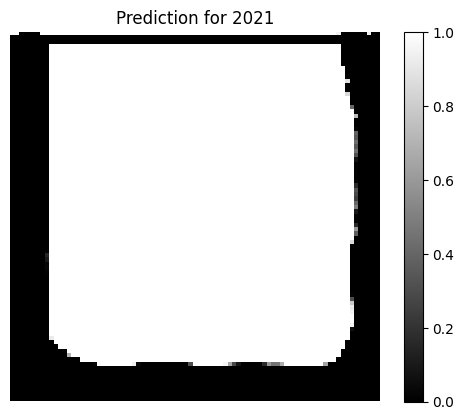

196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step
Saved delta map to: data/filtered/deltas/delta_0.png
Saved delta map to: data/filtered/deltas/delta_1.png
Saved delta map to: data/filtered/deltas/delta_2.png
Saved delta map to: data/filtered/deltas/delta_3.png
Saved delta map to: data/filtered/deltas/delta_4.png
Saved delta map to: data/filtered/deltas/delta_5.png
Saved delta map to: data/filtered/deltas/delta_6.png
Saved delta map to: data/filtered/deltas/delta_7.png
Saved delta map to: data/filtered/deltas/delta_8.png
Saved delta map to: data/filtered/deltas/delta_9.png
Saved delta map to: data/filtered/deltas/delta_10.png
Saved delta map to: data/filtered/deltas/delta_11.png
Saved delta map to: data/filtered/deltas/delta_12.png
Saved delta map to: data/filtered/deltas/delta_13.png
Saved delta map to: data/filtered/deltas/delta_14.png
Saved delta map to: data/filtered/deltas/delta_15.png
Saved delta map to: data/filtered/deltas/delta_16.png
Saved delta map to: data/filtered/deltas/delta_1

In [34]:
import os
import numpy as np
from PIL import Image
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# =============================
# 1. Helper Functions
# =============================

def normalize_image(image):
    """
    Normalize an image to [0, 255].
    """
    image = image.astype(np.float32)  # Convert to float for scaling
    max_value = np.max(image)
    if max_value > 255:
        image = (image / max_value) * 255  # Scale to 0-255 range
    image = np.clip(image, 0, 255)  # Ensure values are in [0, 255]
    return image.astype(np.uint8)  # Convert back to uint8 for image display

def load_image(image_path):
    """
    Load an image using PIL and return as a numpy array.
    """
    image = Image.open(image_path)  # Open image using PIL
    return np.array(image)  # Convert to numpy array

import re

def extract_lat_lon(filename):
    """
    Extract latitude and longitude from the filename.
    """
    match = re.search(r"(-?\d+\.\d+)_(-?\d+\.\d+)", filename)
    if match:
        return match.groups()
    return None

def small_data_test(directory_y, directory_x, substring, num_files, resize_to=(85, 85)):
    """
    Preprocess images from directory_x and directory_y.
    Match files based on latitude and longitude.
    """
    # Select filenames from y directory based on the substring
    filtered_filenames_y = [f for f in os.listdir(directory_y) if substring in f]
    random.seed(42)
    selected_filenames_y = random.sample(filtered_filenames_y, num_files)
    selected_filepaths_y = [os.path.join(directory_y, filename) for filename in selected_filenames_y]

    # Extract lat/lon from X filenames
    lat_lon_to_x_file = {}
    for filename_x in os.listdir(directory_x):
        lat_lon = extract_lat_lon(filename_x)
        if lat_lon:
            lat_lon_to_x_file[lat_lon] = os.path.join(directory_x, filename_x)

    # Match Y filenames to X filenames based on lat/lon
    selected_filepaths_x = []
    for filename_y in filtered_filenames_y:
        lat_lon = extract_lat_lon(filename_y)
        if lat_lon and lat_lon in lat_lon_to_x_file:
            selected_filepaths_x.append(lat_lon_to_x_file[lat_lon])
        else:
            print(f"No matching file in directory_x for: {filename_y}")

    # Process y images (resize to 85x85)
    y_images = []
    for filepath_y in selected_filepaths_y:
        image_y = load_image(filepath_y)
        image_y_resized = np.array(Image.fromarray(image_y).resize(resize_to))  # Resize to (85, 85)
        y_images.append(image_y_resized)
    y_images_resized = np.array(y_images)

    # Process x images (resize and normalize)
    x_images = []
    for filepath_x in selected_filepaths_x:
        image_x = load_image(filepath_x)  # Load the RGB image
        image_x_resized = np.array(Image.fromarray(image_x).resize(resize_to))  # Resize to (85, 85)
        image_x_normalized = normalize_image(image_x_resized)  # Normalize to [0, 255]
        x_images.append(image_x_normalized)
    x_images_normalized = np.array(x_images)

    return x_images_normalized, y_images_resized

# =============================
# 2. Load and Preprocess Data
# =============================
directory_y = 'data/filtered/targets_2021'
directory_x = 'data/filtered/images_2021'
substring = '2021_05'
num_files = 10  # Number of files to process

# Preprocess the data
x_images, y_images = small_data_test(directory_y, directory_x, substring, num_files)

print(f"Processed X Images Shape: {x_images.shape}")
print(f"Processed Y Images Shape: {y_images.shape}")

# =============================
# 3. Load the Model and Predict
# =============================
model = tf.keras.models.load_model('models/trained_model.keras')

# Predict for the processed x_images
predictions_2021 = model.predict(x_images, batch_size=8)  # Adjust batch size as needed

# Example: Display a prediction
plt.imshow(predictions_2021[0].squeeze(), cmap='gray')
plt.title("Prediction for 2021")
plt.colorbar()
plt.axis("off")
plt.show()

# =============================
# 4. Repeat for 2016 Data and Calculate Deltas
# =============================
# Preprocess and predict for 2016
directory_y_2016 = 'data/filtered/targets_2016'
directory_x_2016 = 'data/filtered/images_2016'

x_images_2016, y_images_2016 = small_data_test(directory_y_2016, directory_x_2016, '2016_08', num_files)
predictions_2016 = model.predict(x_images_2016, batch_size=8)  # Adjust batch size as needed

# Calculate deltas
deltas = predictions_2021 - predictions_2016

# =============================
# 5. Visualize and Save Deltas
# =============================
output_dir = 'data/filtered/deltas'
os.makedirs(output_dir, exist_ok=True)

for i in range(len(deltas)):
    plt.imshow(deltas[i].squeeze(), cmap='RdBu', vmin=-1, vmax=1)
    plt.title(f"Delta for Image {i}")
    plt.colorbar()
    plt.axis("off")

    # Save delta map
    output_path = os.path.join(output_dir, f"delta_{i}.png")
    plt.savefig(output_path)
    print(f"Saved delta map to: {output_path}")
    plt.close()

Delta saved for ('-54.96', '-3.69') at data/filtered/deltas
Delta saved for ('-55.18', '-3.79') at data/filtered/deltas
Delta saved for ('-55.12', '-3.43') at data/filtered/deltas
Delta saved for ('-55.00', '-3.61') at data/filtered/deltas
Delta saved for ('-54.50', '-4.25') at data/filtered/deltas
Delta saved for ('-55.14', '-3.37') at data/filtered/deltas
Delta saved for ('-54.64', '-4.19') at data/filtered/deltas
Delta saved for ('-55.06', '-4.35') at data/filtered/deltas
Delta saved for ('-55.14', '-4.17') at data/filtered/deltas
Delta saved for ('-54.64', '-3.39') at data/filtered/deltas
Delta saved for ('-54.68', '-3.77') at data/filtered/deltas
Delta saved for ('-55.14', '-3.91') at data/filtered/deltas
Delta saved for ('-54.74', '-4.17') at data/filtered/deltas
Delta saved for ('-54.66', '-4.35') at data/filtered/deltas
Delta saved for ('-55.04', '-3.39') at data/filtered/deltas
Delta saved for ('-54.58', '-4.33') at data/filtered/deltas
Delta saved for ('-55.08', '-3.77') at d

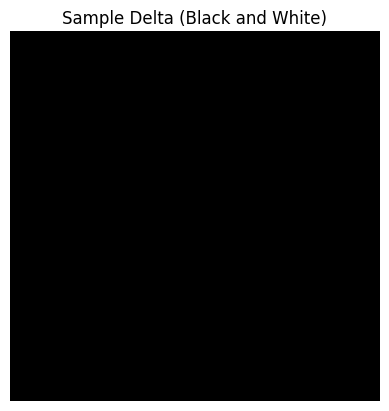

In [96]:
import numpy as np
from PIL import Image
import os
import re
import matplotlib.pyplot as plt

# =============================
# Helper Functions
# =============================

# Function to load an image using PIL
def load_image(image_path):
    """
    Load an image using PIL and return as a numpy array.
    """
    image = Image.open(image_path)
    return np.array(image)

# Extract latitude and longitude from filenames
def extract_lat_lon(filename):
    """
    Extract latitude and longitude from the filename.
    """
    match = re.search(r"(-?\d+\.\d+)_(-?\d+\.\d+)", filename)
    if match:
        return match.groups()
    return None

# =============================
# Preprocessing and Delta Calculation
# =============================

def calculate_delta(images_2021_dir, targets_2021_dir, output_dir, resize_to=(85, 85)):
    """
    Calculate deltas between 2021 predictions (X) and 2021 targets (Y).
    Resulting delta images will be in black and white.
    """
    # Map 2021 images based on latitude/longitude
    lat_lon_to_images = {}
    for filename in os.listdir(images_2021_dir):
        lat_lon = extract_lat_lon(filename)
        if lat_lon:
            lat_lon_to_images[lat_lon] = os.path.join(images_2021_dir, filename)

    # Process 2021 target images and match with 2021 images
    os.makedirs(output_dir, exist_ok=True)
    for target_filename in os.listdir(targets_2021_dir):
        lat_lon = extract_lat_lon(target_filename)
        if lat_lon in lat_lon_to_images:
            # File paths
            image_2021_path = lat_lon_to_images[lat_lon]
            target_2021_path = os.path.join(targets_2021_dir, target_filename)

            # Load and resize the images
            image_2021 = load_image(image_2021_path)
            target_2021 = load_image(target_2021_path)

            image_2021_resized = np.array(Image.fromarray(image_2021).resize(resize_to))
            target_2021_resized = np.array(Image.fromarray(target_2021).resize(resize_to))

            # Normalize the images
            image_2021_normalized = image_2021_resized.astype(np.float32) / 255.0
            target_2021_normalized = target_2021_resized.astype(np.float32) / 255.0

            # Convert RGB to grayscale
            if len(image_2021_normalized.shape) == 3 and image_2021_normalized.shape[2] == 3:
                image_2021_normalized = np.mean(image_2021_normalized, axis=-1)  # Average RGB channels

            # Calculate delta (absolute difference)
            delta = np.abs(image_2021_normalized - target_2021_normalized)
            delta_binary = (delta > 0.5).astype(np.uint8)  # Threshold to binary black-and-white

            # Save the delta image
            delta_image = Image.fromarray((delta_binary * 255).astype(np.uint8))  # Scale to [0, 255]
            delta_image.save(os.path.join(output_dir, f"delta_{lat_lon[0]}_{lat_lon[1]}.png"))
            print(f"Delta saved for {lat_lon} at {output_dir}")

# =============================
# Usage Example
# =============================

# Directories for images and targets
images_2021_dir = 'data/filtered/images_2021'  # Path to 2021 images (X)
targets_2016_dir = 'data/filtered/targets_2016'  # Path to 2016 targets (Y)
output_dir = 'data/filtered/deltas'            # Output directory for delta images

# Calculate deltas
calculate_delta(images_2021_dir, targets_2016_dir, output_dir)

# Optional: Visualize one of the delta maps
sample_delta_path = os.path.join(output_dir, os.listdir(output_dir)[0])
sample_delta = load_image(sample_delta_path)

plt.imshow(sample_delta, cmap="gray")
plt.title("Sample Delta (Black and White)")
plt.axis("off")
plt.show()

((85, 85, 3), (85, 85))

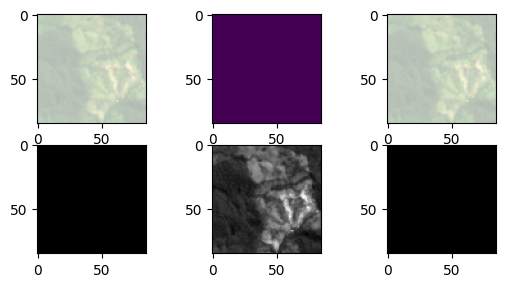

In [98]:
# CODE SNIPPET TO DOUBL-CHECK INDIVIDUAL PICTURES

image_2021_path = "data/filtered/images_2021/Landsat8_SR_RGB_-54.48_-3.61_2021_05_26.tiff"
target_2021_path = "data/filtered/targets_2016/Deforestation_-54.48_-3.61_2016_08_01.tiff"
resize_to=(85, 85)

image_2021 = load_image(image_2021_path)
target_2021 = load_image(target_2021_path)
image_2021_resized = np.array(Image.fromarray(image_2021).resize(resize_to))
target_2021_resized = np.array(Image.fromarray(target_2021).resize(resize_to))
plt.subplot(3,3,1)
plt.imshow(image_2021_resized)
plt.subplot(3,3,2)
plt.imshow(target_2021_resized)

# Normalize the images
image_2021_normalized = image_2021_resized.astype(np.float32) / 255.0
target_2021_normalized = target_2021_resized.astype(np.float32) / 255.0
plt.subplot(3,3,3)
plt.imshow(image_2021_normalized)
plt.subplot(3,3,4)
plt.imshow(target_2021_normalized,cmap="gray")
# Convert RGB to grayscale
if len(image_2021_normalized.shape) == 3 and image_2021_normalized.shape[2] == 3:
    image_2021_normalized = np.mean(image_2021_normalized, axis=-1)  # Average RGB channels

# Calculate delta (absolute difference)
delta = np.abs(image_2021_normalized - target_2021_normalized)
delta_binary = (delta > 0.5).astype(np.uint8)  # Threshold to binary black-and-white
plt.subplot(3,3,5)
plt.imshow(delta, cmap="gray")
plt.subplot(3,3,6)
plt.imshow(delta_binary,cmap="gray")
image_2021_normalized.shape
image_2021.shape, target_2021.shape

